# Set Up Environment

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# XGBoost Model

In [2]:

def xgBoostRegressor(input_file):
    # Load and prepare data
    data = pd.read_csv(input_file)

    # Encode categorical target variable
    label_encoder = LabelEncoder()
    data['Glucose_Level_Range'] = label_encoder.fit_transform(data['Glucose_Level_Range'])

    # Feature/target split
    targets = ['Glucose_15min', 'Glucose_30min', 'Glucose_45min', 'Glucose_60min']
    X = data.drop(targets + ['Time'], axis=1)
    y = data[targets]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    # Parameter grid for optimization
    param_grid = {
        'n_estimators': [100, 200, 300],        # Number of boosting rounds
        'max_depth': [3, 6, 9],                 # Maximum tree depth
        'learning_rate': [0.01, 0.1, 0.2],      # Step size shrinkage
        'subsample': [0.8, 1.0]                 # Subsample ratio of training instances
    }

    # Initialize and run GridSearchCV
    xgb = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        tree_method='hist'  # Faster training on larger datasets
    )
    
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_
    
    # Save the trained model
    save_model_path = 'xgboost_model.json'
    best_model.save_model(save_model_path)
    print(f"\nModel saved to: {save_model_path}")

    # Print best parameters
    print("\nBest Parameters:")
    print(grid_search.best_params_)

    # Evaluate on test set
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nOverall Test Set Evaluation:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")

    # Calculate ±25% error range accuracy for each time point
    print("\nTime-Specific Accuracy (±25%):")
    for i, target in enumerate(targets):
        lower = 0.75 * y_pred[:, i]
        upper = 1.25 * y_pred[:, i]
        accurate = np.sum((y_test[target].values >= lower) & (y_test[target].values <= upper))
        accuracy = accurate / len(y_pred) * 100
        print(f"{target}: {accuracy:.2f}% accurate")

    # Calculate overall ±25% accuracy
    accurate_predictions = np.all(
        (y_test.values >= 0.75 * y_pred) & (y_test.values <= 1.25 * y_pred),
        axis=1
    )
    overall_accuracy = np.mean(accurate_predictions) * 100
    print(f"\nOverall Accuracy (±25% range): {overall_accuracy:.2f}%")

    print('\n\n')

    # Visualise predictions with error patterns
    plt.figure(figsize=(18, 6))
    
    # Actual vs Predicted
    plt.subplot(1, 3, 1)
    target_idx = 0  # Glucose_15min
    plt.scatter(y_test.iloc[:, target_idx], y_pred[:, target_idx], 
               alpha=0.3, color='blue')
    plt.plot([y_test.min().min(), y_test.max().max()], 
             [y_test.min().min(), y_test.max().max()], 
             'r--', lw=1)
    plt.xlabel('Actual Glucose')
    plt.ylabel('Predicted Glucose')
    plt.title(f'Actual vs Predicted ({targets[target_idx]})')
    
    # Error Distribution
    plt.subplot(1, 3, 2)
    errors = y_test.values - y_pred
    plt.boxplot([errors[:, i] for i in range(4)], 
                labels=targets,
                showfliers=False)
    plt.axhline(y=0, color='k', linestyle='--')
    plt.ylabel('Prediction Error (mmol/L)')
    plt.title('Error Distribution by Time Horizon')
    
    # Accuracy by Time Horizon
    plt.subplot(1, 3, 3)
    accuracies = []
    for i in range(4):
        lower = 0.75 * y_pred[:, i]
        upper = 1.25 * y_pred[:, i]
        acc = ((y_test.iloc[:, i] >= lower) & (y_test.iloc[:, i] <= upper)).mean() * 100
        accuracies.append(acc)
    
    plt.bar(targets, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylabel('Accuracy (%)')
    plt.title('±25% Accuracy by Time Horizon')
    plt.tight_layout()
    plt.show()

## T1D Data

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best Parameters:
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Overall Test Set Evaluation:
RMSE: 1.36
MAE: 0.92
R² Score: 0.85

Time-Specific Accuracy (±25%):
Glucose_15min: 98.13% accurate
Glucose_30min: 93.57% accurate
Glucose_45min: 87.38% accurate
Glucose_60min: 80.57% accurate

Overall Accuracy (±25% range): 78.13%





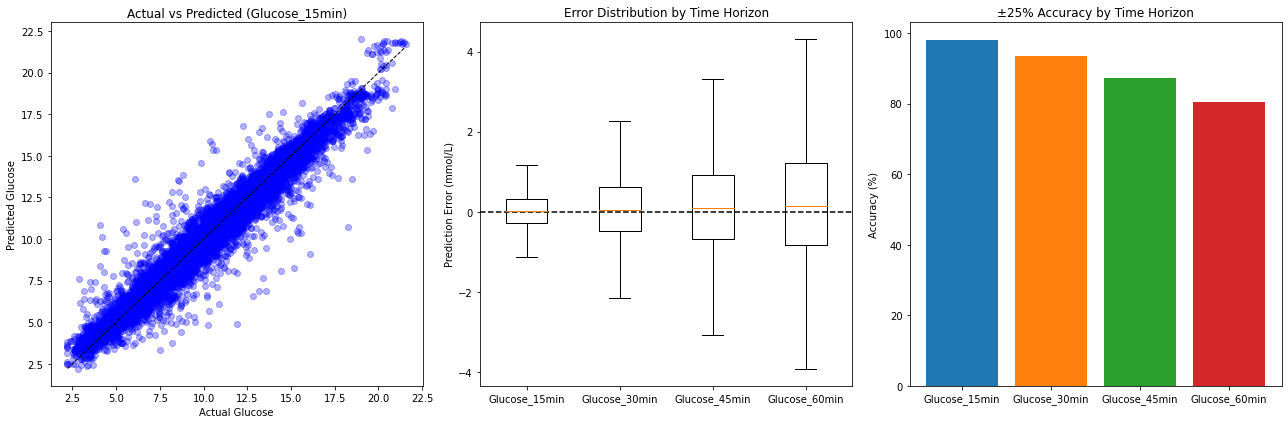

In [27]:
xgBoostRegressor('Processed_Data/T1D_Data/combined_T1D_data.csv')

## T2D Data

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best Parameters:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}

Overall Test Set Evaluation:
RMSE: 2.74
MAE: 1.49
R² Score: 0.79

Time-Specific Accuracy (±25%):
Glucose_15min: 97.55% accurate
Glucose_30min: 90.51% accurate
Glucose_45min: 80.54% accurate
Glucose_60min: 71.53% accurate

Overall Accuracy (±25% range): 69.81%





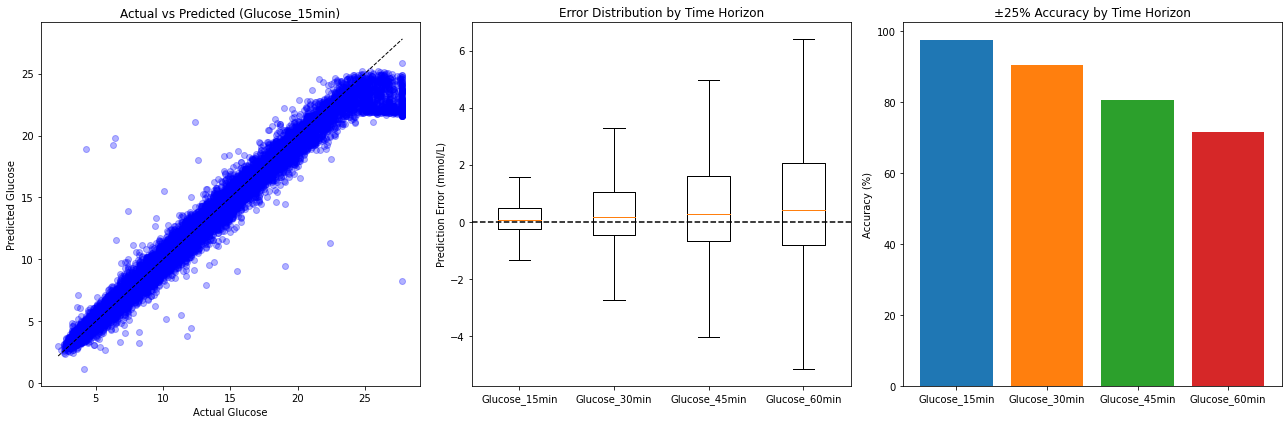

In [28]:
xgBoostRegressor('Processed_Data/T2D_Data/combined_T2D_data.csv')

## Ohio Data

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best Parameters:
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Overall Test Set Evaluation:
RMSE: 1.34
MAE: 0.91
R² Score: 0.86

Time-Specific Accuracy (±25%):
Glucose_15min: 98.55% accurate
Glucose_30min: 93.96% accurate
Glucose_45min: 87.60% accurate
Glucose_60min: 80.81% accurate

Overall Accuracy (±25% range): 78.61%





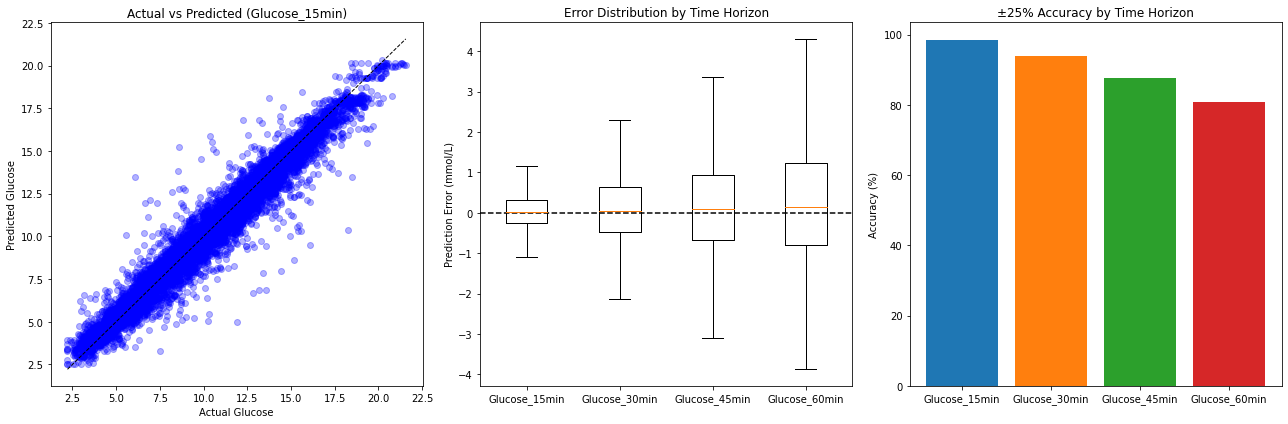

In [29]:
xgBoostRegressor('Processed_Data/T1D_Data/combined_ohio_data.csv')

## Shanghai T1D Data

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

Overall Test Set Evaluation:
RMSE: 1.47
MAE: 1.00
R² Score: 0.84

Time-Specific Accuracy (±25%):
Glucose_15min: 97.50% accurate
Glucose_30min: 89.40% accurate
Glucose_45min: 79.88% accurate
Glucose_60min: 72.86% accurate

Overall Accuracy (±25% range): 69.52%





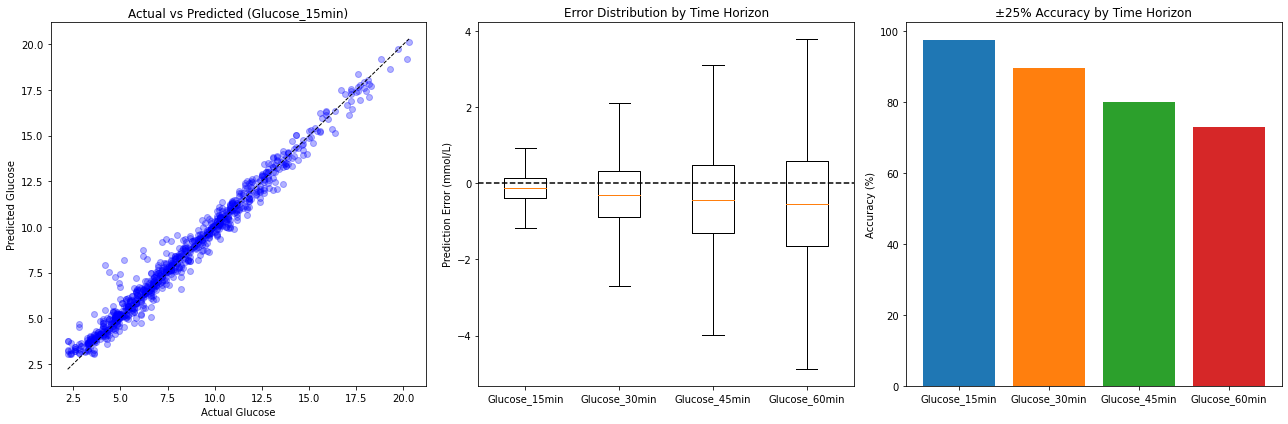

In [30]:
xgBoostRegressor('Processed_Data/T1D_Data/combined_shanghait1d_data.csv')

## Shanghai T2D Data

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best Parameters:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

Overall Test Set Evaluation:
RMSE: 1.02
MAE: 0.66
R² Score: 0.88

Time-Specific Accuracy (±25%):
Glucose_15min: 99.64% accurate
Glucose_30min: 95.38% accurate
Glucose_45min: 90.06% accurate
Glucose_60min: 84.89% accurate

Overall Accuracy (±25% range): 83.12%





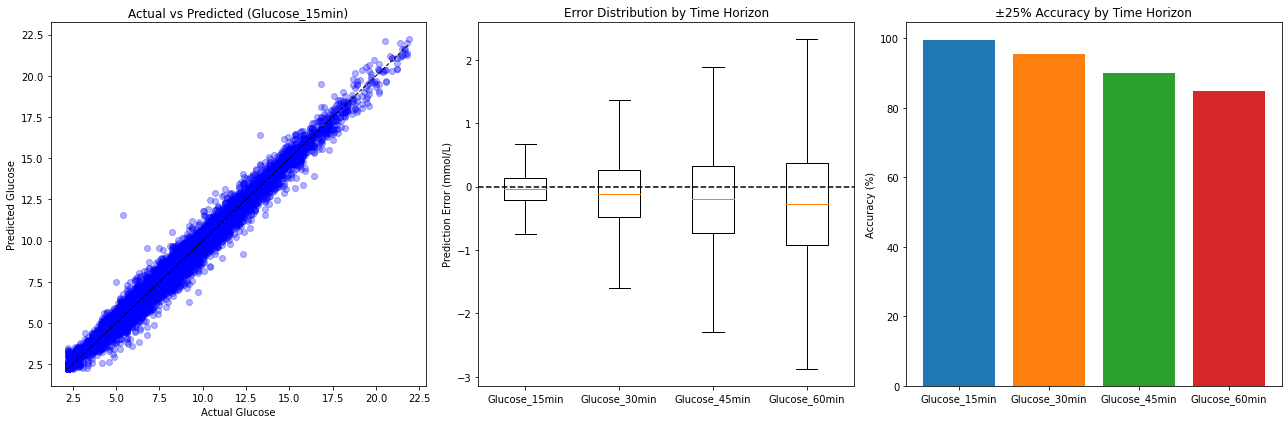

In [31]:
xgBoostRegressor('Processed_Data/T2D_Data/combined_shanghait2d_data.csv')

## Participant Data

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Model saved to: xgboost_model.json

Best Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

Overall Test Set Evaluation:
RMSE: 1.95
MAE: 1.36
R² Score: 0.90

Time-Specific Accuracy (±25%):
Glucose_15min: 99.59% accurate
Glucose_30min: 97.32% accurate
Glucose_45min: 92.52% accurate
Glucose_60min: 86.11% accurate

Overall Accuracy (±25% range): 85.45%





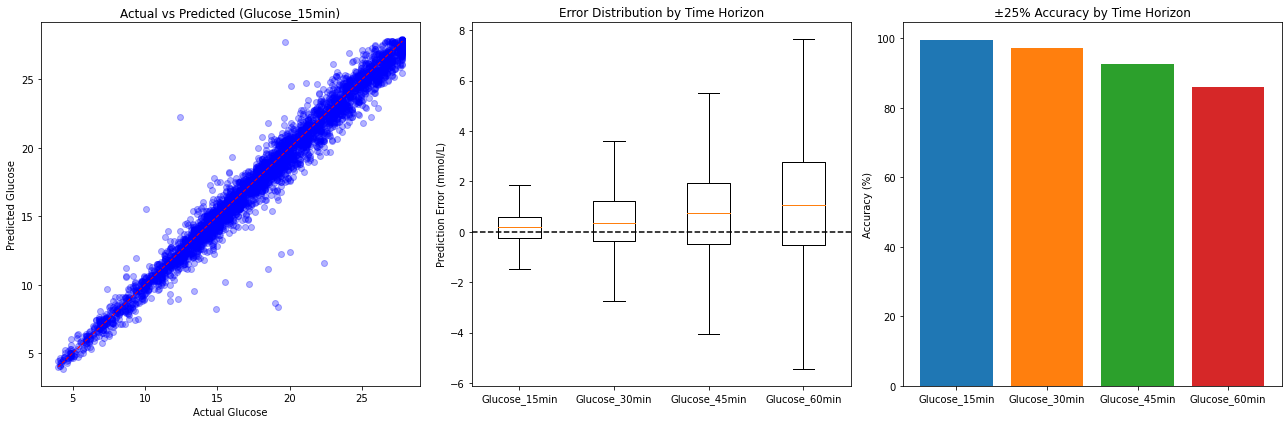

In [3]:
xgBoostRegressor('Processed_Data/T2D_Data/participant_data_processed.csv')